Device: cuda

=== Проверка визуализации SimpleCNN ===


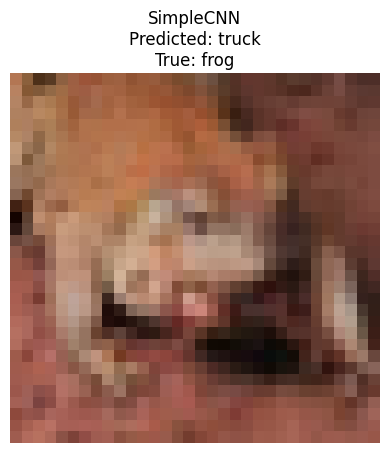

SimpleCNN → Predicted: truck, True: frog

=== Проверка визуализации Adapted ResNet34 ===


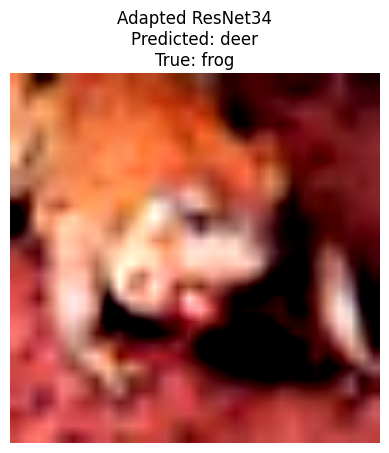

Adapted ResNet34 → Predicted: deer, True: frog


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=simple_transform)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=simple_transform)
train_loader_cifar = torch.utils.data.DataLoader(train_dataset_cifar, batch_size=64, shuffle=True)
test_loader_cifar = torch.utils.data.DataLoader(test_dataset_cifar, batch_size=1000, shuffle=False)

train_dataset_resnet = datasets.CIFAR10(root='./data', train=True, download=True, transform=resnet_transform)
test_dataset_resnet = datasets.CIFAR10(root='./data', train=False, download=True, transform=resnet_transform)
train_loader_resnet = torch.utils.data.DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)
test_loader_resnet = torch.utils.data.DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

def get_adapted_resnet34():
    resnet = models.resnet34(weights=None)
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, 10)
    return resnet

def train_and_evaluate(model, train_loader, test_loader, model_name, num_epochs=5, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, target in tqdm(train_loader, desc=f'{model_name} Epoch {epoch+1}'):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label=f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss over Epochs')
    plt.legend()
    plt.show()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = 100. * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')
    return accuracy, train_losses


def visualize_prediction(model, img_source, transform, model_name, classes, device='cpu', is_url=True, true_label=None):
    try:
        if is_url:
            import urllib.request
            req = urllib.request.Request(img_source, headers={'User-Agent': 'Mozilla/5.0'})
            with urllib.request.urlopen(req) as response:
                img = Image.open(BytesIO(response.read())).convert('RGB')
        else:
            img = Image.fromarray(np.uint8(img_source.permute(1, 2, 0).numpy() * 255))

        img_tensor = transform(img).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            pred_label = output.argmax().item()

        plt.imshow(img)
        title = f'{model_name} Predicted: {classes[pred_label]}'
        if true_label is not None:
            title += f', True: {classes[true_label]}'
        plt.title(title)
        plt.axis('off')
        plt.show()

        print(f'{model_name} Prediction: {classes[pred_label]}')
    except Exception as e:
        print(f"Ошибка загрузки изображения: {e}")


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    print("\n=== Обучение SimpleCNN ===")
    simple_cnn = SimpleCNN()
    simple_acc, simple_losses = train_and_evaluate(simple_cnn, train_loader_cifar, test_loader_cifar, "SimpleCNN", num_epochs=5, device=device)

    print("\n=== Обучение Adapted ResNet34 ===")
    resnet = get_adapted_resnet34()
    resnet_acc, resnet_losses = train_and_evaluate(resnet, train_loader_resnet, test_loader_resnet, "Adapted ResNet34", num_epochs=5, device=device)

    print("\n=== Сравнение результатов ===")
    print(f"SimpleCNN Accuracy: {simple_acc:.2f}%")
    print(f"Adapted ResNet34 Accuracy: {resnet_acc:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(simple_losses, label='SimpleCNN Loss')
    plt.plot(resnet_losses, label='Adapted ResNet34 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Сравнение Training Loss')
    plt.legend()
    plt.show()

    print("\n=== Визуализация SimpleCNN ===")
visualize_from_dataset(simple_cnn, test_dataset_cifar, simple_transform, "SimpleCNN", classes, device, index=12)

print("\n=== Визуализация Adapted ResNet34 ===")
visualize_from_dataset(resnet, test_dataset_resnet, resnet_transform, "Adapted ResNet34", classes, device, index=12)